## 赛事介绍
如今的智能机已经很智能了，如果手机可以觉察到我们在生活中的一举一动，知道我们行动的意图，你觉得会如何？智能手机不仅搭载了多种惯性传感器，这使得基于智能手机的人体行为识别研究越来越受关注。

![](https://ai-studio-static-online.cdn.bcebos.com/849f5b245156468c850ad6adad6f5ba649184a062cb44d128ba504c61652ae8a)

在本次赛题由志愿者使用智能手机时，通过基本活动的行为构建而成。希望选手能够构建模型对活动行为进行预测。

## 赛事任务
实验是在 19-48 岁年龄段的 30 名志愿者中进行的。每个人在腰部佩戴智能手机（三星 Galaxy S II）进行六项活动（步行、楼上步行、楼下步行、坐、站、躺）。实验以 50Hz 的恒定速率捕获 3 轴线性加速度和 3 轴角速度。

赛题训练集案例如下：
- 训练集8千条数据；
- 测试集共2000条数据；

数据总共100MB，赛题数据均为csv格式，列使用逗号分割。若使用Pandas读取数据，可参考如下代码：

```
import pandas as pd
import numpy as np

train = pd.read_csv('train.csv.zip')
```

对于数据集中的每一条记录，都提供了以下内容，来自加速度计的三轴加速度（总加速度）和估计的身体加速度、和来自陀螺仪的三轴角速度。总共是具有时域和频域变量的561个特征向量。

测试集中label字段Activity为空，需要选手预测。

## 评审规则

1. 数据说明：选手需要提交测试集队伍排名预测，具体的提交格式如下：
```
Activity
STANDING
LAYING
WALKING
SITTING
WALKING
WALKING_DOWNSTAIRS
STANDING
```

2. 评估指标：本次竞赛的使用准确率进行评分，数值越高精度越高，评估代码参考：
```
from sklearn.metrics import accuracy_score
y_pred = [0, 2, 1, 3]
y_true = [0, 1, 2, 3]
accuracy_score(y_true, y_pred)
```

## 数据分析
解压数据集，对数据集进行数学分析。

In [1]:
import pandas as pd
import paddle
import numpy as np

%pylab inline
import seaborn as sns

train_df = pd.read_csv('data/data137267/train.csv.zip')
test_df = pd.read_csv('data/data137267/test.csv.zip')

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


Populating the interactive namespace from numpy and matplotlib


In [2]:
train_df.shape#查看训练数据的尺寸

(8000, 562)

In [3]:
train_df.columns#查看每列的数据项

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


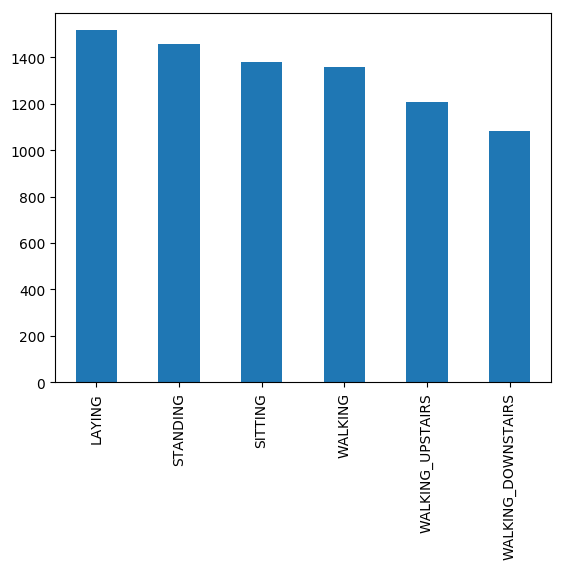

In [4]:
train_df['Activity'].value_counts().plot(kind='bar')#绘制行为数量的直方图进行分析，

# 利用盒须图进行分析
通过盒须图可以看出一组数据的离散程度，聚集区间，更好的都异常数据进行处理


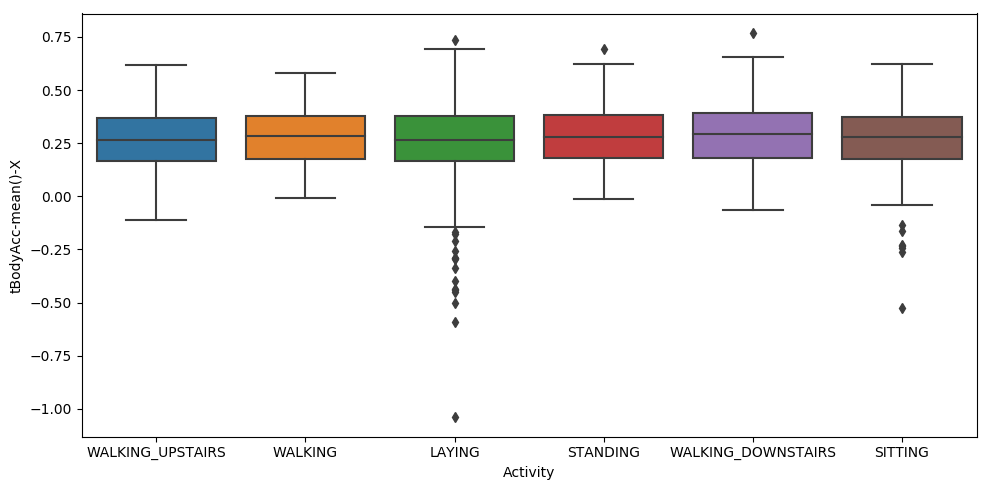

In [5]:
plt.figure(figsize=(10, 5))
sns.boxplot(y='tBodyAcc-mean()-X', x='Activity', data=train_df)
plt.tight_layout()

In [6]:
#对不同的行为进行编号
train_df['Activity'] = train_df['Activity'].map({
    'LAYING': 0,
    'STANDING': 1,
    'SITTING': 2,
    'WALKING': 3,
    'WALKING_UPSTAIRS': 4,
    'WALKING_DOWNSTAIRS': 5
})

In [7]:
#对数据进行归一化处理
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_df.values[:, :-1])
train_df.iloc[:, :-1] = scaler.transform(train_df.values[:, :-1])
test_df.iloc[:, :] = scaler.transform(test_df.values)

## 搭建模型

In [8]:
class Classifier(paddle.nn.Layer):
    # self代表类的实例自身
    def __init__(self):
        # 初始化父类中的一些参数
        super(Classifier, self).__init__()
        
        self.conv1 = paddle.nn.Conv1D(in_channels=1, out_channels=16, kernel_size=3)
        self.conv2 = paddle.nn.Conv1D(in_channels=16, out_channels=32, kernel_size=3)
        self.conv3 = paddle.nn.Conv1D(in_channels=32, out_channels=64, kernel_size=3)
        self.flatten = paddle.nn.Flatten()
        self.dropout = paddle.nn.Dropout()
        self.fc = paddle.nn.Linear(in_features=128, out_features=6)
        self.relu = paddle.nn.ReLU()
        self.pool = paddle.nn.MaxPool1D(6)
        self.softmax = paddle.nn.Softmax()


    # 网络的前向计算
    def forward(self, inputs):
        x = self.pool(self.relu(self.conv1(inputs)))
        x = self.pool(self.relu(self.conv2(x)))

        x = self.dropout(x)
        x = self.pool(self.relu(self.conv3(x)))
        x = self.dropout(x)

        x = self.flatten(x)
        x = self.relu(self.fc(x))
        x = self.softmax(x)
        return x

In [13]:
model = Classifier()
model.train()
opt = paddle.optimizer.SGD(learning_rate=0.005, parameters=model.parameters())#这里利用SGD机型梯度下降学习，也可以选择其他更好的算法，学习率为0.005，可以选择更改
loss_fn = paddle.nn.CrossEntropyLoss()#选择交叉熵损失函数

In [24]:
EPOCH_NUM = 120   # 设置外层循环次数
BATCH_SIZE = 64  # 设置batch大小，我这里batch_size选择32，不同于基线的优化；
training_data = train_df.iloc[:-1000].values.astype(np.float32)
val_data = train_df.iloc[-1000:].values.astype(np.float32)

training_data = training_data.reshape(-1, 1, 562)
val_data = val_data.reshape(-1, 1, 562)

In [25]:
# 定义外层循环
for epoch_id in range(EPOCH_NUM):
    # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
    np.random.shuffle(training_data)
    
    # 将训练数据进行拆分，每个batch包含10条数据
    mini_batches = [training_data[k:k+BATCH_SIZE] for k in range(0, len(training_data), BATCH_SIZE)]
    
    # 定义内层循环
    for iter_id, mini_batch in enumerate(mini_batches):
        model.train()
        x = np.array(mini_batch[:,:, :-1]) # 获得当前批次训练数据
        y = np.array(mini_batch[:,:, -1:]) # 获得当前批次训练标签
        
        # 将numpy数据转为飞桨动态图tensor的格式
        features = paddle.to_tensor(x)
        y = paddle.to_tensor(y)
        
        # 前向计算
        predicts = model(features)
        
        # 计算损失
        loss = loss_fn(predicts, y.flatten().astype(int))
        avg_loss = paddle.mean(loss)

        # 反向传播，计算每层参数的梯度值
        avg_loss.backward()
        # 更新参数，根据设置好的学习率迭代一步
        opt.step()
        # 清空梯度变量，以备下一轮计算
        opt.clear_grad()

        # 训练与验证
        if iter_id%2000==0 and epoch_id % 10 == 0:
            acc = predicts.argmax(1) == y.flatten().astype(int)
            acc = acc.astype(float).mean()

            model.eval()
            val_predict = model(paddle.to_tensor(val_data[:, :, :-1])).argmax(1)
            val_label = val_data[:, :, -1]
            val_acc = np.mean(val_predict.numpy() == val_label.flatten())

            print("epoch: {}, iter: {}, loss is: {}, acc is {} / {}".format(
                epoch_id, iter_id, avg_loss.numpy(), acc.numpy(), val_acc))

epoch: 0, iter: 0, loss is: [1.5405304], acc is [0.53125] / 0.565
epoch: 10, iter: 0, loss is: [1.5101113], acc is [0.53125] / 0.574
epoch: 20, iter: 0, loss is: [1.5105559], acc is [0.5] / 0.575
epoch: 30, iter: 0, loss is: [1.4914882], acc is [0.484375] / 0.572
epoch: 40, iter: 0, loss is: [1.4923491], acc is [0.53125] / 0.58
epoch: 50, iter: 0, loss is: [1.5760813], acc is [0.4375] / 0.589
epoch: 60, iter: 0, loss is: [1.5089864], acc is [0.5] / 0.587
epoch: 70, iter: 0, loss is: [1.4688275], acc is [0.578125] / 0.595
epoch: 80, iter: 0, loss is: [1.5000999], acc is [0.5] / 0.598
epoch: 90, iter: 0, loss is: [1.439268], acc is [0.609375] / 0.591
epoch: 100, iter: 0, loss is: [1.5067945], acc is [0.53125] / 0.592
epoch: 110, iter: 0, loss is: [1.4889367], acc is [0.546875] / 0.604


In [26]:
paddle.save(model.state_dict(),"work"+"/"+"save_dir_final.pdparams")

In [21]:
model.eval()
test_data = paddle.to_tensor(test_df.values.reshape(-1, 1, 561).astype(np.float32))
test_predict = model(test_data)
test_predict = test_predict.argmax(1).numpy()

In [22]:
test_predict = pd.DataFrame({'Activity': test_predict})
test_predict['Activity'] = test_predict['Activity'].map({
    0:'LAYING',
    1:'STANDING',
    2:'SITTING',
    3:'WALKING',
    4:'WALKING_UPSTAIRS',
    5:'WALKING_DOWNSTAIRS'
})

In [23]:
test_predict.to_csv('submission.csv', index=None)

!zip submission.zip submission.csv

updating: submission.csv (deflated 94%)


# 总结
这个项目的基线优化的空间很大，训练的轮数，batch-size的大小等等，
还可以进行数据增强，加入噪声等，如上面所说，引入残差网络，避免梯度消失等，
也可以选择其他的方式，SVM+boosting增强也是个不错的方式，准确率也极高